# Scratch Detection Assignment

## Description

In this assignment you are receiving wafer maps in a certain operation and the goal is to predict whether a given die belongs to scratch or not.

The data includes information about individual dies from a number of wafers.

The table data includes the following columns:

- `WaferName` : The name of the wafer from which the die came.
- `DieX`: The horizontal position of the die on the wafer.
- `DieY`: The vertical position of the die on the wafer.
- `IsGoodDie`: A binary column indicating whether the die is good or not.
- `IsScratchDie`: A binary column indicating whether the die belongs to a scratch or not.

Your goal is to use the training data to build a model that can predict, given a certain wafer map, the dies on the map that are parts of a scratch (whether they are bad, 'Scratch' or good, 'Ink').

In addition to the training data, you are given a test set, which includes the x and y coordinates and the good/not status of each die, but does not include the scratch/not scratch labels. 

You are asked to use your model to predict the scratch/not scratch status of the dies in the test set, and to save the predictions in a CSV file.


In [1]:
import pandas as pd
import zipfile
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils import data as data
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from clearml import Task, Logger, OutputModel
import segmentation_models_pytorch as smp
from tqdm import tqdm
import random

# Build your solution
I decided to solve this issue from the computer vision prospective.<br>
In that way i can take advantage of the spatial dimension of the wafers.<br>
I worked on it as a segmentation task.

<font size="6">**Setting training number for tracking with Clearml**</font><br>
I used clearml platform to track of my experiments and document them.<br>
I documented the model architecture, configuration and loss and dice score graphs. 

In [2]:
train_number = 99

<font size="6">**Define GPU support**</font>

In [2]:
# Define GPU support
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080 Ti


<font size="6">**Define Functions**</font> <br>
1. Count the number of samples of each class for the entire dataset.<br>
2. Show some random images from data loader.<br>
3. Calculate mean and std of dataset.<br>
4. Calculates dice score.<br>
5. Validation function for the training process.<br>
6. Test function for the test dataset.<br>
7. Show some random images and masks from test set.<br>

In [3]:
def count_labels(loader, title):
    """count the number of samples of each class for the entire dataset and print a distribution chart.

    Parameters
    ----------
    loader : pytorch dataloader
        The dataloader we want to count.
    title : string
        The title of the chart.

    Returns
    -------
    None
    """
    labels = []
    for i in range(len(loader.dataset)):
        label = 'scratch' if loader.dataset[i][1].max() > 0 else 'no scratch'
        labels.append(label)

    train_Y = pd.DataFrame(labels)
    train_Y.rename(columns={0:'wafers'},inplace=True)
    plt.figure(figsize=(3,5))
    chart = sns.countplot(data=train_Y, x='wafers')
    plt.title(title)

def show_random_imgs(data_loader, amount, norm = False):
    """Show some random images and masks from data loader.

    Parameters
    ----------
    data_loader : pytorch dataloader
        The dataloader that contains the dataset.
    amount : int
        The amount of images to show.
    norm : boolean
        True - data normalized.
        False - data didn't normalized.

    Returns
    -------
    None
    """
    images, masks = next(iter(data_loader))

    if norm == True:
        mean = [0.0276, 0.2347, 0.0]
        std = [0.1637, 0.4238, 1.0]
    else:
        mean= [0,0,0]
        std = [1,1,1]

    rows = 2
    columns = amount

    plt.figure()
    for i in range(amount):
        fig = plt.subplot(rows, columns, i + 1)
        images[i][0] = images[i][0]*std[0] + mean[0]
        images[i][1] = images[i][1]*std[1] + mean[1]
        images[i][2] = images[i][2]*std[2] + mean[2]
        plt.imshow(np.transpose(images[i].to('cpu').numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title('Image')

        fig = plt.subplot(rows, columns, amount + i + 1)
        plt.imshow(np.transpose(masks[i].to('cpu').numpy(), (1, 2, 0)), cmap='gray')
        plt.axis('off')
        wafer_class = 'scratch' if masks[i].max() > 0 else 'no scratch'
        plt.title(f'Mask ({wafer_class})')
    
    plt.subplots_adjust(right=1 + 2*float(f'0.{columns}'), top=1 )

def get_mean_and_std(dataloader):
    """calculate mean and std of dataset.

    Parameters
    ----------
    dataloader : pytorch dataloader
        The dataloader we want to count.

    Returns
    -------
    mean : list
        The mean values for each channel.
    std : list
        The standard deviation values for each channel.
    """
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for img, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(img, dim=[0,2,3])
        channels_squared_sum += torch.mean(img**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

def dice_score(preds, masks):
    """Calculates dice score.

    Parameters
    ----------
    preds : pytorch tensor
        The predictions.
    masks : pytorch tensor
        The Ground Truth.

    Returns
    -------
    dice_score : float
        The Dice Score.
    """
    dice = 0
    for i in range(preds.shape[0]):
        if torch.sum(preds[i] + masks[i]) == 0:
            dice += 1
        else:
            dice += (2 * (preds[i] * masks[i]).sum()) / ((preds[i] + masks[i]).sum() + 1e-8)
    
    return dice/preds.shape[0]

def validate(model, loss_func, val_loader):
    """Validation function for the training process.

    Parameters
    ----------
    model : pytorch nn.Module
        The deep learning model.
    loss_func : pytorch loss function
        The model loss function.
    val_loader : pytorch dataloader
        The validation dataloader.

    Returns
    -------
    val_loss : float
        The validation loss.
    val_dice_score : float
        The validation dice score.
    """
    val_loss = 0
    val_dice_score = 0

    for i, (images,masks) in enumerate(val_loader):
        images = images.to(device)
        masks = masks.to(device)

        val_output = model(images)
        val_loss += loss_func(val_output, masks).item()
         
        preds = torch.sigmoid(val_output)
        preds = (preds > 0.5).float()
        val_dice_score += dice_score(preds, masks)
    
    val_loss = val_loss/len(val_loader)
    val_dice_score = val_dice_score/len(val_loader)

    return val_loss, val_dice_score

def test(model, dataloader, df_wafers_test):
    """Test function for the test dataset.

    Parameters
    ----------
    model : pytorch nn.Module
        The deep learning model.
    dataloader : pytorch dataloader
        The test dataloader.
    df_wafers_test : pd DataFrame
        The test dataset csv.

    Returns
    -------
    IsScratchDie : list
        List corresponding to the test csv wafer test with True/False for scratch die.
    imgs : np array
        Store all the test images.
    prediction : np array
        Store all the test masks.
    """
    prediction = []
    imgs = []

    for i, (images,_) in enumerate(dataloader):
        images = images.to(device)
        imgs.extend(images.to('cpu').numpy())
        masks = model.predict(images)
        prediction.extend(masks.to('cpu').numpy())

    IsScratchDie = []
    df_len = len(df_wafers_test.groupby('WaferName',sort=False).all())
    df_sort= df_wafers_test.groupby('WaferName').all().to_dict('split')['index']
    for i in tqdm(range(df_len)):
        df_name = df_wafers_test.groupby('WaferName',sort=False).all().index[i]
        mask = prediction[df_sort.index(df_name)]
        wafer = df_wafers_test.groupby('WaferName').get_group(df_name)

        wafer_ScratchDie = np.zeros((len(wafer)), dtype=np.uint8)
        for j in range(len(wafer)):
            wafer_ScratchDie[j] = mask[0,wafer.iloc[j][1], wafer.iloc[j][2]].item()
        
        IsScratchDie.extend(wafer_ScratchDie.astype(bool))

    return IsScratchDie, imgs, prediction

def show_test_samples(imgs, prediction, df_wafers_test, amount):
    """Show some random images and masks from test set.

    Parameters
    ----------
    imgs : np array
        Store all the test images.
    prediction : np array
        Store all the test masks.
    df_wafers_test : pd DataFrame
        The test dataset csv.
    amount : int
        The amount of images to show.

    Returns
    -------
    None
    """
    amount = 6
    indx = random.sample(range(0, len(imgs)), amount)
    mean = [0.0276, 0.2347, 0.0]
    std = [0.1637, 0.4238, 1.0]

    rows = 2
    columns = amount
    im = np.copy(imgs)
    plt.figure()
    j = 0
    for i in indx:
        df_name = df_wafers_test.groupby('WaferName',sort=False).all().index[i]
        wafer =  df_wafers_test.groupby('WaferName').get_group(df_name)
        mes = 'Yield: ' + str(round((wafer['IsGoodDie']).sum()/(wafer['IsGoodDie']).count(), 2)) 

        fig = plt.subplot(rows, columns, j + 1)
        im[i][0] = imgs[i][0]*std[0] + mean[0]
        im[i][1] = imgs[i][1]*std[1] + mean[1]
        im[i][2] = imgs[i][2]*std[2] + mean[2]

        plt.imshow(np.transpose(im[i], (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Input | Wafer Name: {df_name}, \nSum: {len(wafer)} dies. {mes}')
        fig = plt.subplot(rows, columns, amount + j + 1)
        
        plt.imshow(np.transpose(prediction[i], (1, 2, 0)), cmap='gray')
        plt.axis('off')
        wafer_class = 'scratch' if prediction[i].max() > 0 else 'no scratch'
        plt.title(f'Mask ({wafer_class})')

        j += 1

    plt.subplots_adjust(right=1.5 + 2*float(f'0.{columns}'), top=1.2)

<font size="6">**Define Wafers Dataset class**</font> <br>
To use the data as images i converted the csv files to numpy arrays and saved them.<br>
In that way, i don't need to convert the wafers to images every time, just once.<br>
I added the files in the data folder for faster use.

In [4]:
class WafersDataset(Dataset):
    """Wafers Dataset"""
    
    def __init__(self, csv_file_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.

        """
        self.df_wafers = pd.read_csv(csv_file_dir)
        self.transform = transform
        self.x_len = 128 
        self.y_len = 128 
        self.dataset_length = len(self.df_wafers.groupby('WaferName'))

        if os.path.isfile(f'data\imgs_{os.path.basename(csv_file_dir).split(".")[0]}.npy') == False or os.path.isfile(f'data\masks_{os.path.basename(csv_file_dir).split(".")[0]}.npy') == False:
            self.imgs = np.zeros((self.dataset_length, self.x_len, self.y_len, 3), dtype=np.uint8)
            self.masks = np.zeros((self.dataset_length, self.x_len, self.y_len, 1), dtype=np.uint8)
            
            for j in range(self.dataset_length):
                wafer = self.df_wafers.groupby('WaferName').get_group(self.df_wafers.groupby('WaferName').all().index[j])
                for i, _ in enumerate(wafer.index):
                    if wafer.iloc[i][3] == True:
                        self.imgs[j, wafer.iloc[i][1], wafer.iloc[i][2], 1] = 255
                    else:
                        self.imgs[j, wafer.iloc[i][1], wafer.iloc[i][2], 0] = 255
                    
                    if 'test' not in csv_file_dir and wafer.iloc[i][4] == True:
                        self.masks[j, wafer.iloc[i][1], wafer.iloc[i][2], 0] = 255

            np.save(f'data\imgs_{os.path.basename(csv_file_dir).split(".")[0]}.npy', self.imgs)
            np.save(f'data\masks_{os.path.basename(csv_file_dir).split(".")[0]}.npy', self.masks)
        else:
            self.imgs = np.load(f'data\imgs_{os.path.basename(csv_file_dir).split(".")[0]}.npy')
            self.masks = np.load(f'data\masks_{os.path.basename(csv_file_dir).split(".")[0]}.npy')

    def __len__(self):
        """
        get dataset length.

        """
        return self.dataset_length
        
    def __getitem__(self, idx):
        """
        Arguments:
            idx (string): Wafer Name.

        """
        img = self.imgs[idx]
        mask = self.masks[idx]

        if self.transform:
            img = self.transform(img)
            mask = transforms.functional.to_tensor(mask)

        return img, mask


<font size="6">**Loading the dataset**</font><br>
1. Define paths to train and test csv folder.<br>
2. Define preprocessing transforms.<br>
3. Loading the data from folders.<br>
4. Split the dataset to training and validation - 80% training and 20% validation.

In [6]:
# Loading the dataset
train_per = 0.8
val_per = 0.2
train_path = os.path.join('data', 'df_wafers.csv')
test_path = os.path.join('data', 'df_wafers_test.csv')

# preprocessing
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0276, 0.2347, 0.0], std=[0.1637, 0.4238, 1.0])
    ]
)

# load the data
wafer_dataset = WafersDataset(train_path, train_transforms)
wafer_dataset_test = WafersDataset(test_path, train_transforms)

# split the data to training and validation
train_data_len = int(len(wafer_dataset) * train_per)
val_data_len = int(len(wafer_dataset) * val_per)
train_dataset, val_dataset = data.random_split(wafer_dataset, [train_data_len, val_data_len], generator=torch.Generator().manual_seed(42))

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(wafer_dataset_test)}')

Train samples: 3136, Validation samples: 784, Test samples: 439


<font size="6">**Encapsulate the data into dataloader form**</font><br>
Batch size is 100.<br>
Shows some random training images and masks.

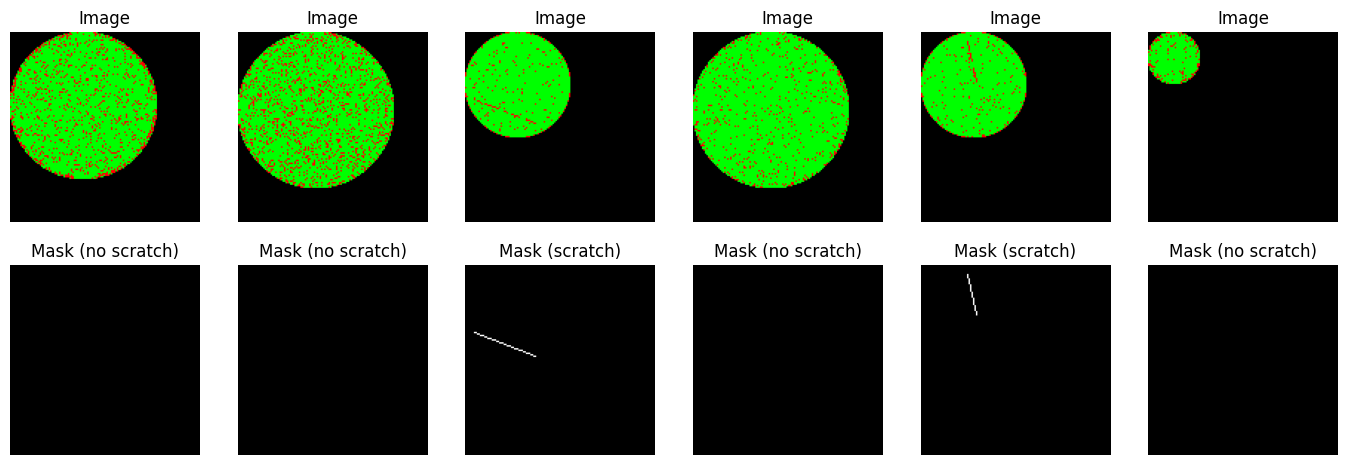

In [7]:
# encapsulate data into dataloader form
batch_size = 100
train_wafer_dataloader= data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_wafer_dataloader= data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_wafer_dataloader= data.DataLoader(wafer_dataset_test, batch_size=batch_size, shuffle=False)

# show some random training images
show_random_imgs(train_wafer_dataloader, 6, True)

<font size="6">**Count the number of samples of each class for the training dataset**</font><br>
We can see that the dataset is almost perfectly balanced for the training set.

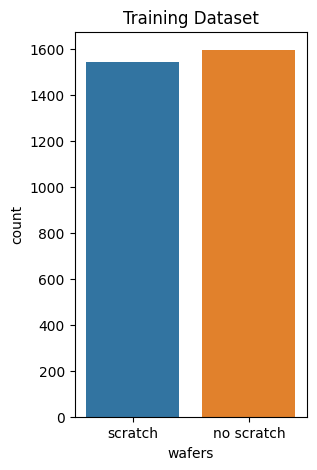

In [8]:
# count the number of samples in each class for training dataset
count_labels(train_wafer_dataloader, 'Training Dataset')

<font size="6">**Count the number of samples of each class for the validation dataset**</font><br>
We can see that the dataset is almost perfectly balanced for the validation set.

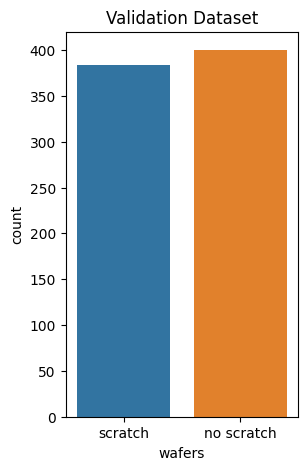

In [9]:
# count the number of samples in each class for all dataset
count_labels(val_wafer_dataloader, 'Validation Dataset')

<font size="6">**Building the CNN models**</font><br>
Segmentation model.<br>
At first i tried to build simple encoder - decoder architecture.

In [13]:
class Model_1(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(Model_1, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.Dropout2d(0.1),
            nn.ConvTranspose2d(in_channels=64, out_channels=out_channels, kernel_size=1, stride=1),
            nn.Dropout2d(0.1)
        )

    def forward(self, x):
        return self.model(x)
    
model_1 = Model_1(3,1).to(device)
summary(model_1,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
         Dropout2d-2         [-1, 64, 128, 128]               0
       BatchNorm2d-3         [-1, 64, 128, 128]             128
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,728
         Dropout2d-7          [-1, 128, 64, 64]               0
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         294,912
        Dropout2d-12          [-1, 256, 32, 32]               0
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

<font size="6">**Training graphs for model_1.**</font><br>
78% on Validation Dice Score.<br>
You can see that the results not so high and there is room for improvement.

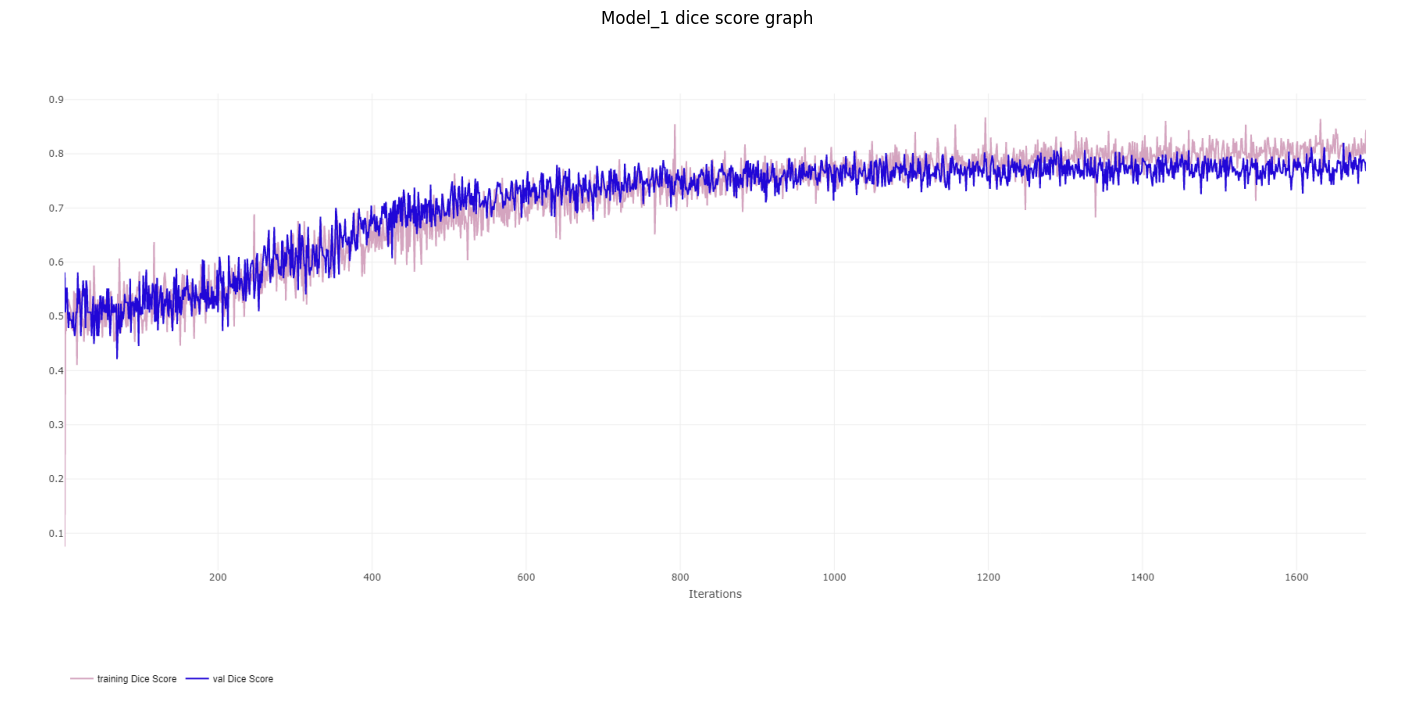

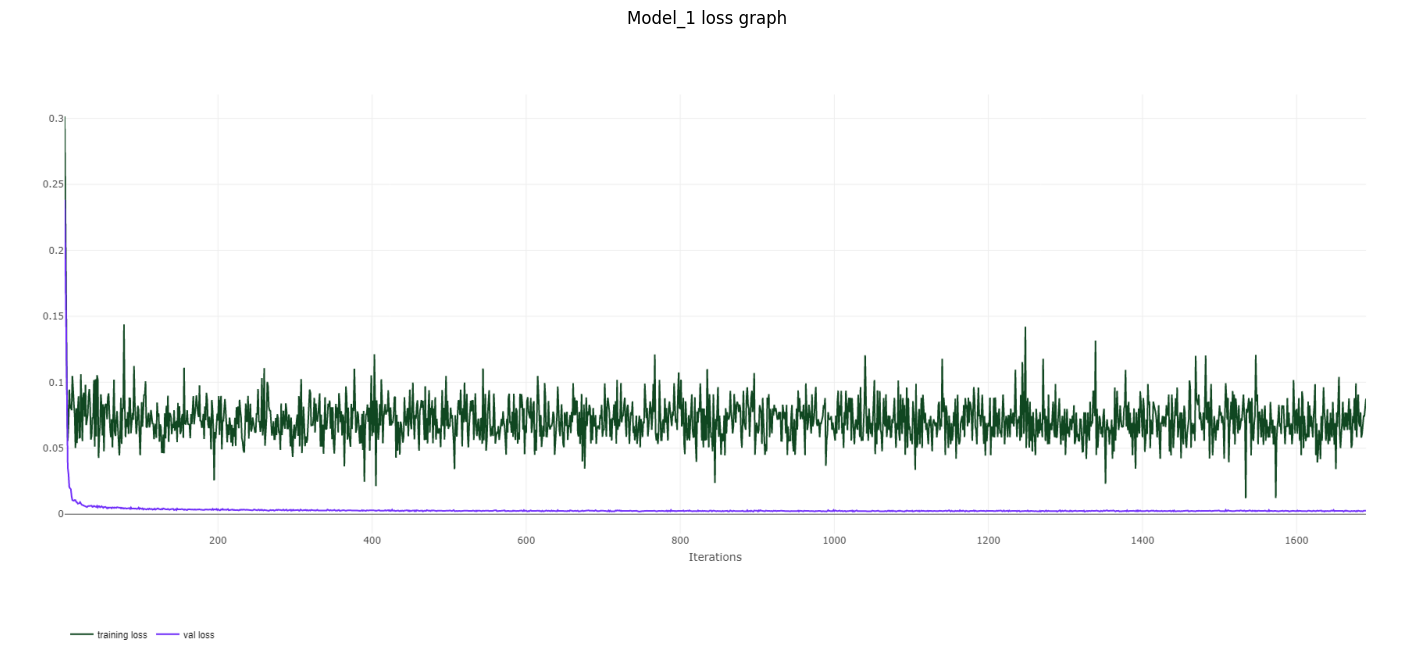

In [16]:
model_1_dice_score_graph = plt.imread('plots/model_1 dice score.png')
model_1_loss_graph = plt.imread('plots/model_1 loss.png')

plt.figure(figsize=(18,20))
plt.imshow(model_1_dice_score_graph)
plt.title('Model_1 dice score graph')
plt.axis('off')

plt.figure(figsize=(18,20))
plt.imshow(model_1_loss_graph)
plt.title('Model_1 loss graph')
f =plt.axis('off')

<font size="6">**Building Model_2_Unet**</font><br>
Segmentation model based on UNET architecture.<br>
At this part i tried to use the unet architecture and manually implement it.<br>

I added the model file for testing, you can load it in "Load the model" section.

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(0.1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class Model_2_Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]) -> None:
        super(Model_2_Unet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of Unet
        for feature in features:
            self.downs.append(DoubleConv(in_channels=in_channels, out_channels=feature))
            in_channels = feature

        # Up part of Unet
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(in_channels=2*feature, out_channels=feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(in_channels=2*feature, out_channels=feature))

        # bottom part of Unet
        self.bottom = DoubleConv(in_channels=features[-1], out_channels=features[-1]*2)

        # last part of Unet
        self.final_conv = nn.Sequential(
            nn.Conv2d(in_channels=features[0], out_channels=out_channels, kernel_size=1, bias= False),
            nn.Dropout2d(0.1)
        )

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottom(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)

        return self.final_conv(x)
    
    def predict(self, x):
        preds = torch.sigmoid(self.forward(x))
        preds = (preds > 0.5).float()

        return preds

model_2_unet = Model_2_Unet(in_channels=3, out_channels=1).to(device)
summary(model_2_unet,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
         Dropout2d-2         [-1, 64, 128, 128]               0
       BatchNorm2d-3         [-1, 64, 128, 128]             128
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
         Dropout2d-6         [-1, 64, 128, 128]               0
       BatchNorm2d-7         [-1, 64, 128, 128]             128
              ReLU-8         [-1, 64, 128, 128]               0
        DoubleConv-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]          73,728
        Dropout2d-12          [-1, 128, 64, 64]               0
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

<font size="6">**Training graphs for model_2_unet.**</font><br>
93.3% on Validation Dice Score.<br>
You can see that the results are significantly better and no overfitting.<br>
This is the best model from all with the best results.

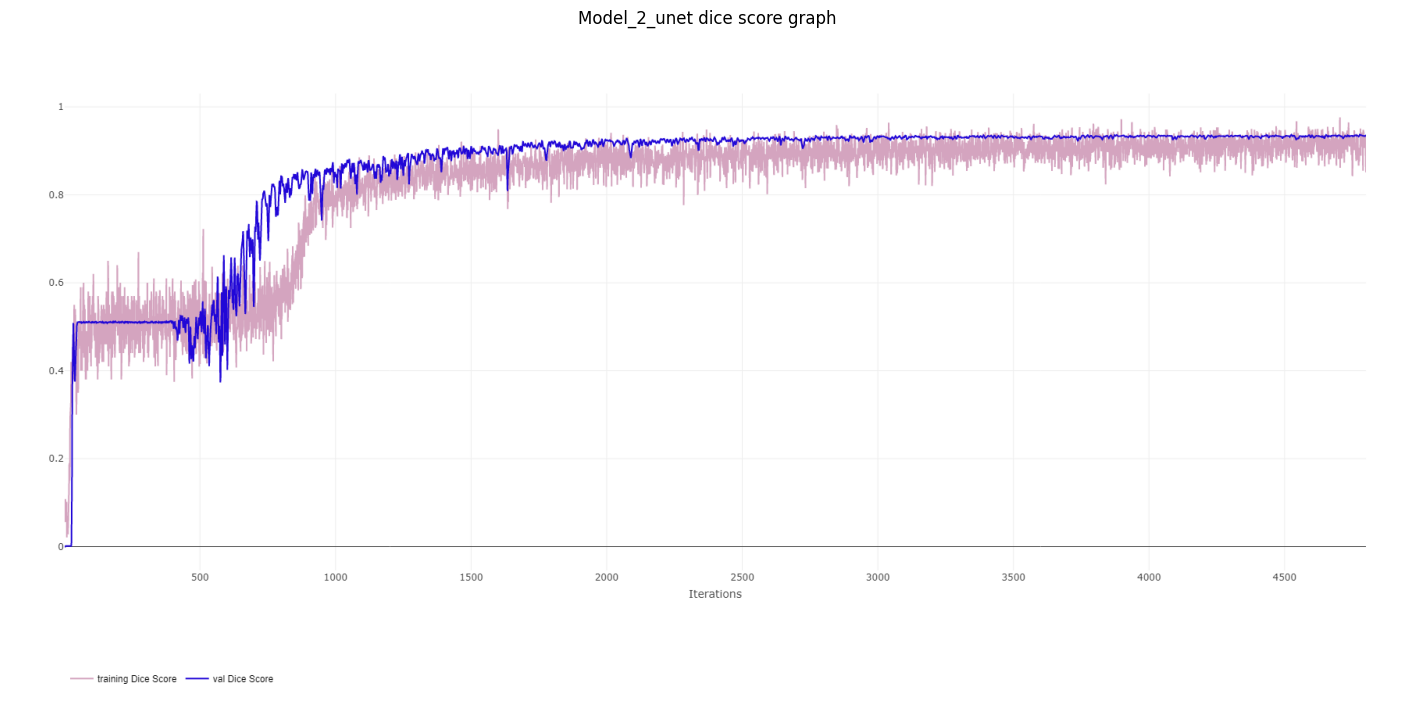

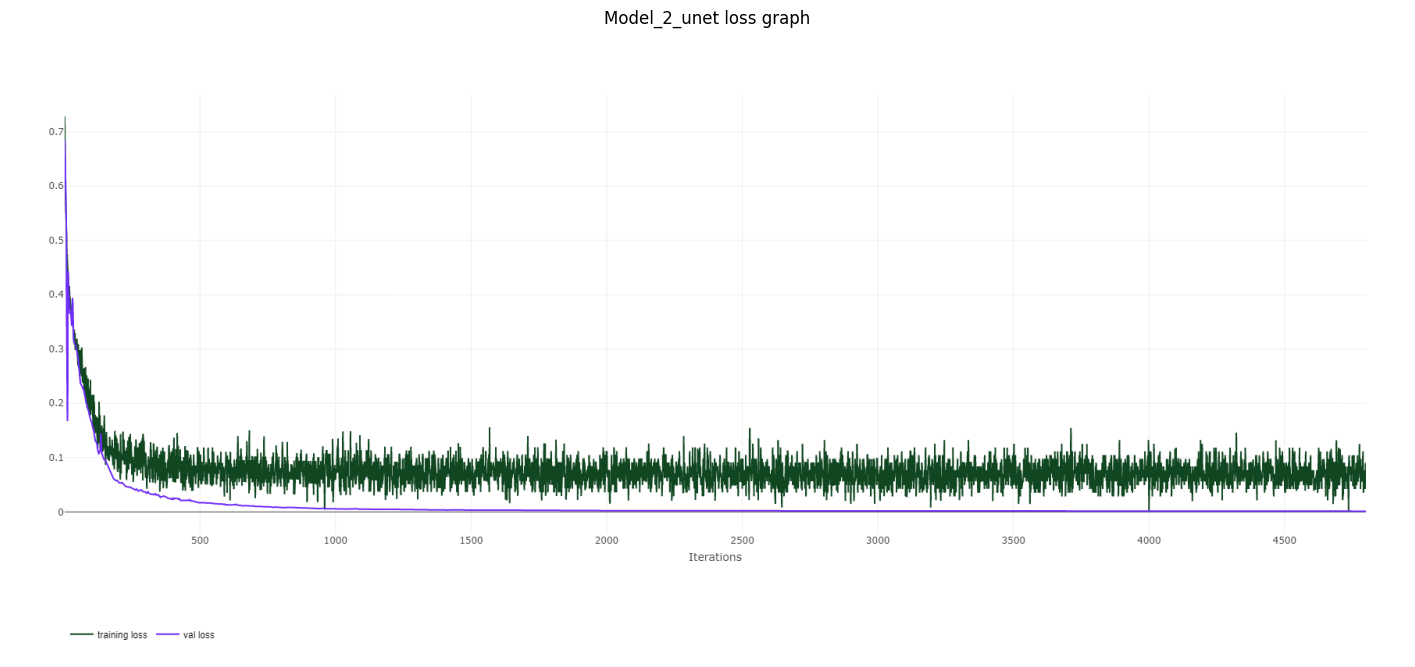

In [17]:
model_2_unet_dice_score_graph = plt.imread('plots/model_2_unet dice score.png')
model_2_unet_loss_graph = plt.imread('plots/model_2_unet loss.png')

plt.figure(figsize=(18,20))
plt.imshow(model_2_unet_dice_score_graph)
plt.title('Model_2_unet dice score graph')
plt.axis('off')

plt.figure(figsize=(18,20))
plt.imshow(model_2_unet_loss_graph)
plt.title('Model_2_unet loss graph')
f =plt.axis('off')

<font size="6">**Model_Unet based on pretrained model**</font><br>
Pretrained segmentation model based on UNET architecture.<br>
Lastly i tried to use the pretrained unet model architecture from segmentation_models_pytorch library.

In [15]:
model_Unet = smp.Unet(
    encoder_name='resnet34',
    encoder_weights= "imagenet",
    in_channels=3,
    classes=1,
).to(device)

model_Unet.segmentation_head.insert(1,nn.Dropout2d(0.3))
summary(model_Unet,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

<font size="6">**Training graphs for model_Unet.**</font><br>
84% on Validation Dice Score.<br>
You can see that the results are better than the first model but not from the second's.<br>

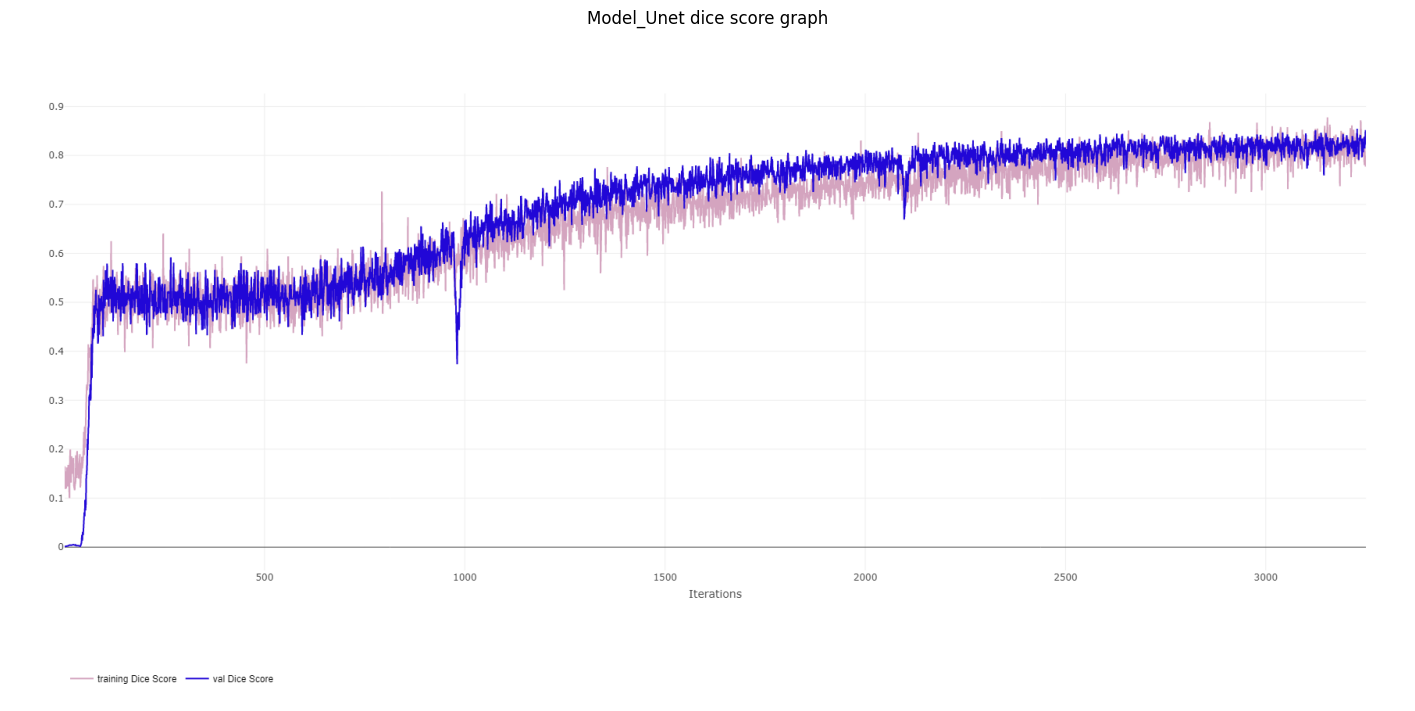

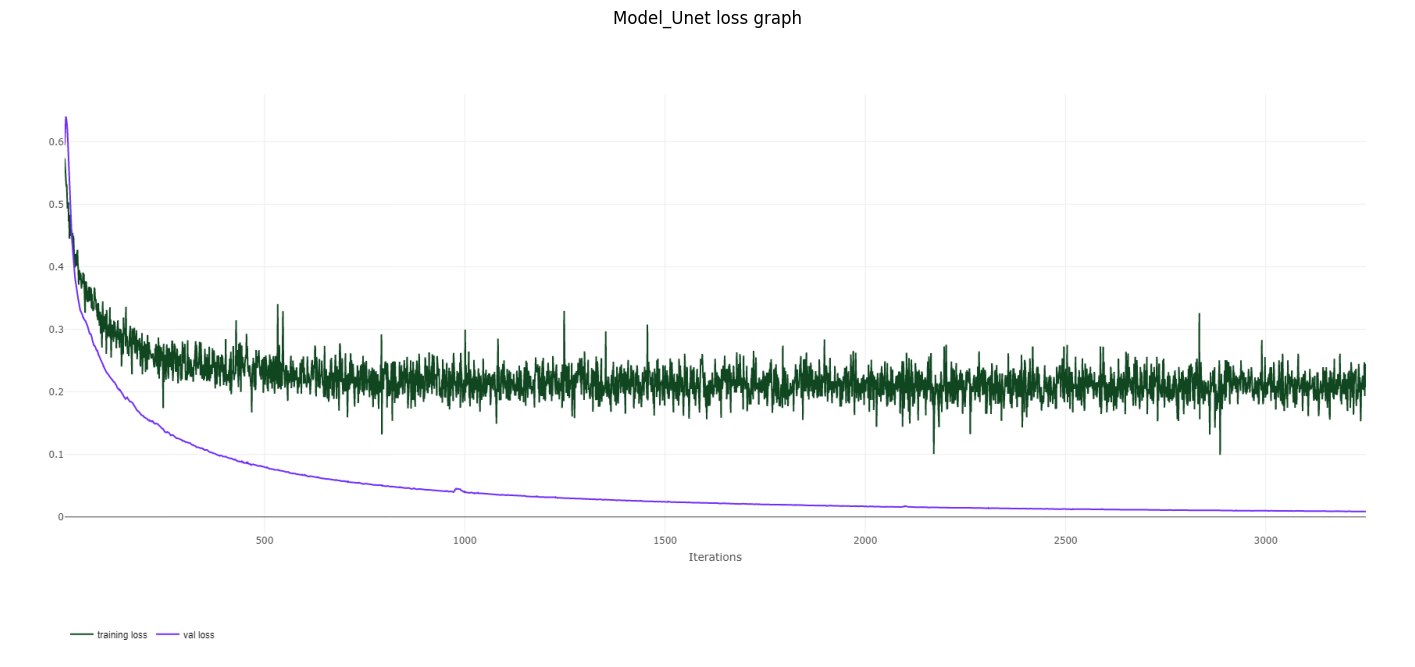

In [18]:
model_Unet_dice_score_graph = plt.imread('plots/model_Unet dice score.png')
model_Unet_loss_graph = plt.imread('plots/model_Unet loss.png')

plt.figure(figsize=(18,20))
plt.imshow(model_Unet_dice_score_graph)
plt.title('Model_Unet dice score graph')
plt.axis('off')

plt.figure(figsize=(18,20))
plt.imshow(model_Unet_loss_graph)
plt.title('Model_Unet loss graph')
f =plt.axis('off')

<font size="6">**Performing the training process.**</font><br>
<font size="5"> It was used for all the model's training.</font>
1. Loss Function: BCEWithLogitsLoss.<br>
2. Optimizer: Adam.<br>
3. Initial Learning Rate: 0.001 and drops CosineAnnealingLR to 0.0001.<br>
4. Number of epochs: 150.<br>

The cell output is not the best running output.

In [9]:
# Add ClearML task
train_number += 1
task = Task.init(project_name="Scratch_Detection", task_name=f"model_1 training {train_number}")

# train the model
learning_rate = 0.0007
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=130, eta_min=0.0001, verbose=True)
epochs = 150
n_total_steps = len(train_wafer_dataloader)
train_loss= []
train_dice_score = 0
train_dice_score_list = []
val_loss_list = []
val_dice_score_list = []
iterations = 0
model_1.train()

# update hyper parameters to ClearML
params = {
    "number_of_epochs": epochs,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "loss_func": "BCEWithLogitsLoss",
    "optimizer": optimizer.__module__,
    "Image_Size": 128,
    "Drop lr": f"CosineAnnealingLR from 0.0007 to 0.0001",
    "model": "model_Unet"
}
params = task.connect(params)

# upload model architecture to ClearML
output_model = OutputModel(task=task)
output_model.update_design(config_dict=model_1.__dict__['_modules'])

# starting the training loop
for epoch in range(epochs):
    for i, (images,masks) in enumerate(train_wafer_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        output = model_1(images)
        loss = loss_func(output, masks)
        
        # calculate training accuracy
        with torch.no_grad():
            preds = torch.sigmoid(output)
            preds = (preds > 0.5).float()
            train_dice_score = dice_score(preds, masks)
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model_1.eval()

        # updating training loss and accuracy to clearml server
        Logger.current_logger().report_scalar("Loss", "training loss", iteration=iterations, value=loss.item())
        Logger.current_logger().report_scalar("Dice Score","training Dice Score", iteration=iterations, value=train_dice_score)

        # calculate validation loss and accuracy
        with torch.no_grad():
            val_loss, val_dice_score = validate(model_1, loss_func, val_wafer_dataloader)

        # updating validation loss and accuracy to clearml server
        Logger.current_logger().report_scalar("Loss", "val loss", iteration=iterations, value=val_loss)
        Logger.current_logger().report_scalar("Dice Score","val Dice Score", iteration=iterations, value=val_dice_score)

        learning_rate = optimizer.param_groups[0]['lr']

        print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}, Training Dice Score: {train_dice_score:.4f}, Validation Loss: {val_loss:.4f}, Validation Dice Score: {val_dice_score:.4f}, lr = {learning_rate}')
        model_1.train()
    
    scheduler.step()

# close ClearML task
task.close()

print('Finished Training')

ClearML Task: created new task id=9539a7be23584f77b71bf20f50c2f418
2023-04-15 12:12:35,798 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2023-04-15 12:12:35,799 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/69656ba6658d4e81bd0e37e2d5572e00/experiments/9539a7be23584f77b71bf20f50c2f418/output/log
Adjusting learning rate of group 0 to 7.0000e-04.
Epoch [1/130], Step [1/13], Training Loss: 0.3015, Training Dice Score: 0.0753, Validation Loss: 0.2383, Validation Dice Score: 0.5811, lr = 0.0007
Epoch [1/130], Step [2/13], Training Loss: 0.2073, Training Dice Score: 0.5156, Validation Loss: 0.1789, Validation Dice Score: 0.5078, lr = 0.0007
Epoch [1/130], Step [3/13], Training Loss: 0.1437, Training Dice Score: 0.4727, Validation Loss: 0.1103, Validation Dice Score: 0.5518, lr = 0.0007
Epoch [1/130], Step [4/13], Training Loss: 0.0886, Training Dice Score: 0.5078, 

<font size="6">**Save the model.**</font><br>

In [123]:
# save the model
path =  f'models/model_2_unet_{train_number}.pth'
torch.save(model_2_unet.state_dict(), path)

<font size="6">**Load the model.**</font><br>

In [12]:
# load model
model_loaded = Model_2_Unet().to(device=device)
model_loaded.load_state_dict(torch.load(f'models/model_2_unet_88.pth'))
model_loaded.eval()

Model_2_Unet(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Dropout2d(p=0.1, inplace=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): Dropout2d(p=0.1, inplace=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Dropout2d(p=0.1, inplace=False)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddin

# Additional thoughts

Here you can detail about anything you want to mention as additional considerations for this solution, anything from ideas, thoughts, considerations about deployment or anything you may have raised when working on this task in a team.

There are more ways for improvement, such as:<br>
1. Better or deeper model.<br>
2. More data (natural or with augmentation).<br>
3. Different ways of training like loss function, optimizer, learning rate, etc.<br>
4. Different way of data presentation as an image.<br>

# Submission
Predict if dies part of scratch or not and show some test samples.<br>
To skip the prediction step (after you done it once), and show test samples faster, mark line 2 as a comment.

100%|██████████| 439/439 [02:19<00:00,  3.14it/s]


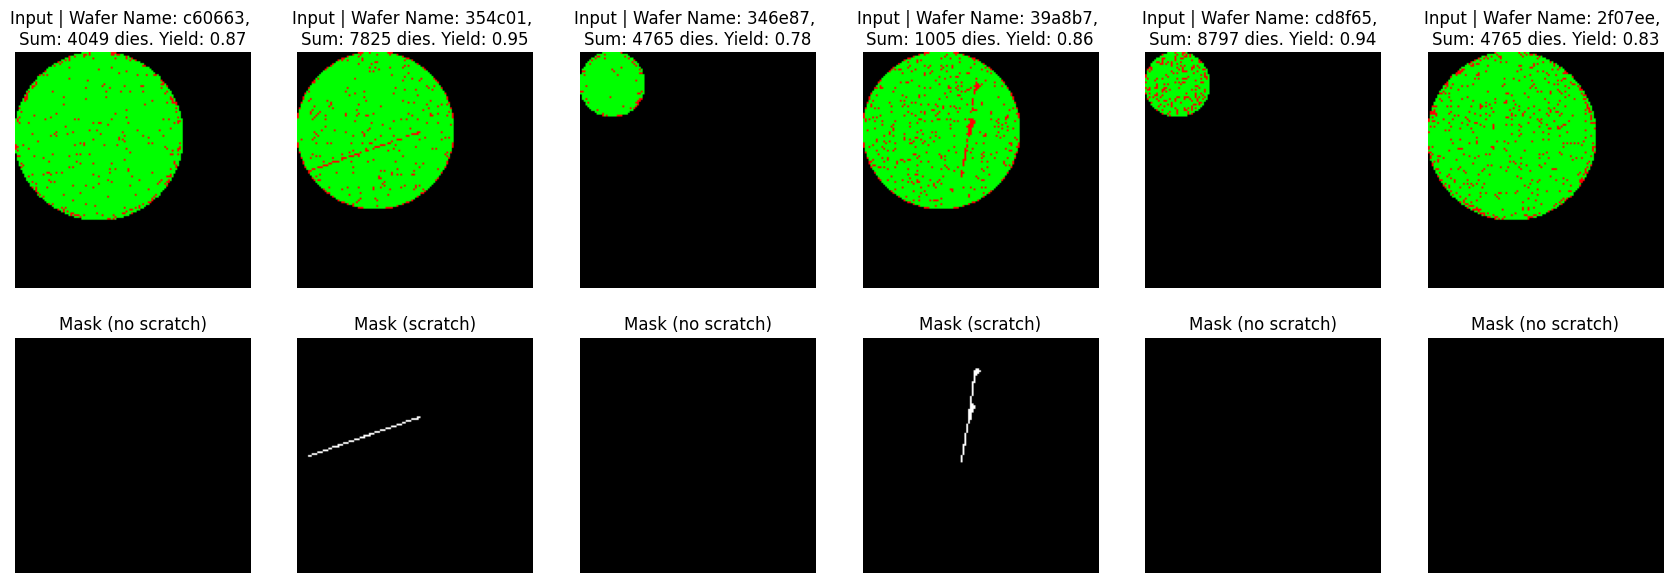

In [15]:
df_wafers_test = pd.read_csv(test_path)
IsScratchDie, imgs, preds = test(model_loaded, test_wafer_dataloader, df_wafers_test)
df_wafers_test['IsScratchDie'] = IsScratchDie
show_test_samples(imgs, preds, df_wafers_test, 6)
df_wafers_test.to_csv('df_wafers_test_with_preds.csv', index=False)